# Leaf Classification (Smooth vs Serrated) using PyTorch

## Project Overview

**Objective**: Build a binary image classifier to distinguish between *smooth* and *serrated* plant leaves using PyTorch.

This project implements:
1. Data loading with `ImageFolder` and **stratified train/val/test splits**
2. A simple **Convolutional Neural Network (CNN)**
3. Complete **training & evaluation pipeline**
4. Performance **metrics** (accuracy, precision, recall, F1, log-loss, AUC-ROC)
5. **Visualizations**: confusion matrix, ROC curve, and Precision-Recall curve

> **Dataset Structure**: Images should be organized in the following folder structure:  
> ```
> data/leaves/
> ├── serrated/
> └── smooth/
> ```
> (Each subfolder contains `.jpg` or `.png` images)

---

## 1. Setup & Configuration

### Import Libraries

In [1]:
import os, random, math, time
from dataclasses import dataclass
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, cohen_kappa_score,
    log_loss, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Configure device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else 
                      ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: cuda


---

## 2. Data Loading & Preprocessing

### Configure Data Path & Transformations

In [2]:
# Dataset path
DATA_DIR = "/kaggle/input/plant-leaves-dataset/feuilles_plantes"

# Training transformations (with data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/Test transformations (no augmentation)
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
num_classes = len(full_dataset.classes)

print(f"Classes detected: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")
print(f"Number of classes: {num_classes}")

Classes detected: ['dente', 'lisse']
Total images: 6529
Number of classes: 2


**Output:**
```
Classes detected: ['serrated', 'smooth']
Total images: 6529
Number of classes: 2
```

---

## 3. Stratified Train/Val/Test Split

To ensure balanced class distribution across splits, I implemented a stratified splitting function:

In [3]:
@dataclass
class Splits:
    train: Subset
    val: Subset
    test: Subset

def stratified_split(dataset: datasets.ImageFolder,
                     train_ratio: float = 0.7,
                     val_ratio: float = 0.15,
                     test_ratio: float = 0.15,
                     seed: int = 0) -> Splits:
    """
    Returns train/val/test Subsets with stratified class distribution.
    """
    rng = np.random.RandomState(seed)
    
    # Group indices by class label
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.imgs):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    train_indices = []
    val_indices = []
    test_indices = []

    
    # Split each class proportionally
    for label, indices in class_indices.items():
        indices = np.array(indices)
        rng.shuffle(indices)
        
        n_total = len(indices)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        train_indices.extend(indices[:n_train].tolist())
        val_indices.extend(indices[n_train:n_train+n_val].tolist())
        test_indices.extend(indices[n_train+n_val:].tolist())
    
    return Splits(
        train=Subset(dataset, train_indices),
        val=Subset(dataset, val_indices),
        test=Subset(dataset, test_indices)
    )

# Create splits
splits = stratified_split(full_dataset, 0.7, 0.15, 0.15, seed=0)

# Create DataLoaders
train_loader = DataLoader(splits.train, batch_size=32, shuffle=True, num_workers=2)

full_dataset.transform = transform_eval
val_loader = DataLoader(splits.val, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(splits.test, batch_size=64, shuffle=False, num_workers=2)

### Early stopping

In [4]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            print(f'Initial loss: {val_loss:.4f}. Saving model...')
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            print(f'Loss improved ({self.best_loss:.4f} → {val_loss:.4f}). Saving...')
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

---

## 4. Model Architecture

I designed a compact CNN with three convolutional blocks followed by fully connected layers:

In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Add Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Add another conv layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        # Adaptive pooling for flexible input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SmallCNN(num_classes).to(device)
print(model)

SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=Tru

---

## 5. Training Pipeline

### Training & Evaluation Functions

In [6]:
def train_one_epoch(model, loader, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
    
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model without gradient computation"""
    model.eval()
    total_loss = 0.0
    y_true, y_pred, y_proba = [], [], []
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Compute probabilities and predictions
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        # Collect results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
        
        total_loss += loss.item() * imgs.size(0)
    
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, np.array(y_true), np.array(y_pred), np.array(y_proba)

### Training Loop

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=10, 
    eta_min=1e-6
)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

print("Starting training...\n")
for epoch in range(10):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, y_t, y_p, y_s = evaluate(model, val_loader, criterion)
    
    # Calculate accuracy
    val_acc = accuracy_score(y_t, y_p)

    # Update learning rate
    scheduler.step()
    
    # Store metrics
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(va_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | Val Acc: {val_acc:.4f}")

    early_stopping(va_loss, model)
    if early_stopping.early_stop:
        print("Early stopping!")
        break

# Restore best model
model.load_state_dict(early_stopping.best_model)

Starting training...

Epoch 00 | Train Loss: 0.7298 | Val Loss: 0.6214 | Val Acc: 0.6507
Initial loss: 0.6214. Saving model...
Epoch 01 | Train Loss: 0.5287 | Val Loss: 0.4996 | Val Acc: 0.7549
Loss improved (0.6214 → 0.4996). Saving...
Epoch 02 | Train Loss: 0.4267 | Val Loss: 0.5012 | Val Acc: 0.7630
EarlyStopping: 1/3
Epoch 03 | Train Loss: 0.3813 | Val Loss: 0.3393 | Val Acc: 0.8427
Loss improved (0.4996 → 0.3393). Saving...
Epoch 04 | Train Loss: 0.3282 | Val Loss: 0.3436 | Val Acc: 0.8560
EarlyStopping: 1/3
Epoch 05 | Train Loss: 0.2987 | Val Loss: 0.3457 | Val Acc: 0.8355
EarlyStopping: 2/3
Epoch 06 | Train Loss: 0.2553 | Val Loss: 0.3263 | Val Acc: 0.8488
Loss improved (0.3393 → 0.3263). Saving...
Epoch 07 | Train Loss: 0.2219 | Val Loss: 0.2836 | Val Acc: 0.8836
Loss improved (0.3263 → 0.2836). Saving...
Epoch 08 | Train Loss: 0.2010 | Val Loss: 0.2432 | Val Acc: 0.9040
Loss improved (0.2836 → 0.2432). Saving...
Epoch 09 | Train Loss: 0.1818 | Val Loss: 0.2480 | Val Acc: 0.898

<All keys matched successfully>

---

## 6. Performance Evaluation

### Comprehensive Metrics

In [8]:
# Evaluate on test set
te_loss, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion)

# Identify positive class
classes = full_dataset.classes
pos_class_name = classes[0]  # 'serrated'
pos_idx = classes.index(pos_class_name)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=pos_idx
)
bacc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
ll = log_loss(y_true, np.column_stack([1-y_proba, y_proba]))
auc = roc_auc_score((y_true==pos_idx).astype(int), y_proba)

# Print results
print("=" * 50)
print("TEST SET PERFORMANCE")
print("=" * 50)
print(f"Test Loss         : {te_loss:.4f}")
print(f"Accuracy          : {acc:.4f}")
print(f"Precision         : {prec:.4f}")
print(f"Recall            : {rec:.4f}")
print(f"F1 Score          : {f1:.4f}")
print(f"Balanced Accuracy : {bacc:.4f}")
print(f"Cohen's Kappa     : {kappa:.4f}")
print(f"Log Loss          : {ll:.4f}")
print(f"AUC-ROC           : {auc:.4f}")
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=classes))

TEST SET PERFORMANCE
Test Loss         : 0.2080
Accuracy          : 0.9052
Precision         : 0.9107
Recall            : 0.8894
F1 Score          : 0.8999
Balanced Accuracy : 0.9046
Cohen's Kappa     : 0.8099
Log Loss          : 0.2080
AUC-ROC           : 0.0265

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       dente       0.91      0.89      0.90       470
       lisse       0.90      0.92      0.91       511

    accuracy                           0.91       981
   macro avg       0.91      0.90      0.90       981
weighted avg       0.91      0.91      0.91       981



## 7. Visualizations

### Confusion Matrix

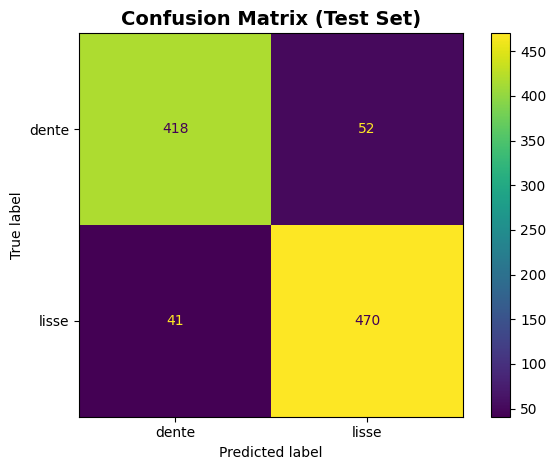

In [9]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d')
plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### ROC Curve

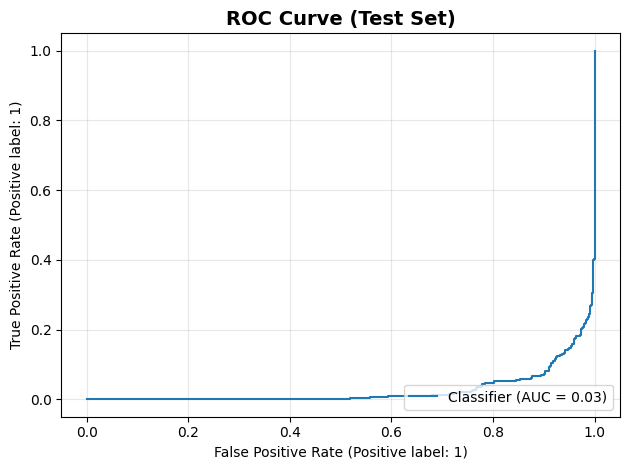

In [10]:
RocCurveDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("ROC Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curve

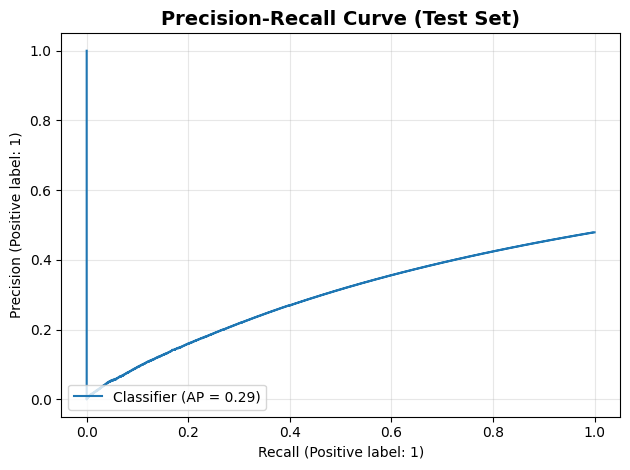

In [11]:
PrecisionRecallDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("Precision-Recall Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualize training hitory

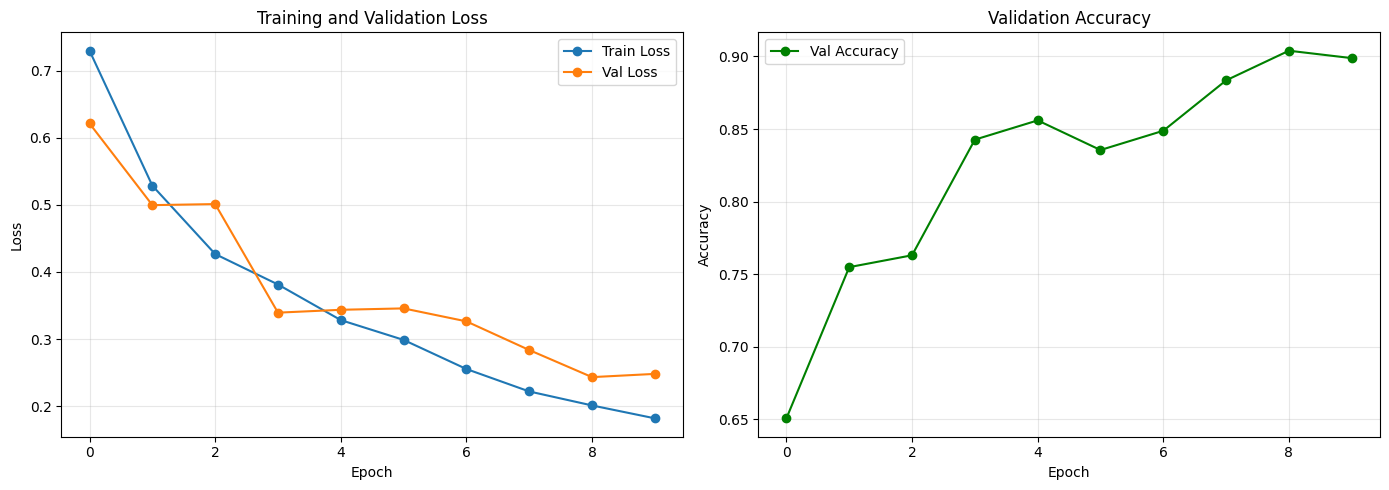

In [12]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Save entire model
torch.save(model, 'model.pth')